<a href="https://colab.research.google.com/github/AnnaBea99/Steam_MVP/blob/main/steam_games_classificacao_mvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Classificação de Jogos Bem Avaliados no Steam

**Autor:** _ANNA BEATRIZ DA CRUZ COSTA_  

**Data:** 20/09/2025

**Matrícula:** 4052025001382

**Dataset:** Ex: [Steam Games](https://huggingface.co/datasets/FronkonGames/steam-games-dataset/discussions?status=open&sort=recently-created)

Este notebook treina modelos de Machine Learning para prever se um jogo será **bem avaliado** no Steam com base em atributos como preço, número de reviews, tempo de jogo e gêneros.


## 1. Escopo, objetivo e definição do problema

Este trabalho tem como objetivo prever se um jogo será considerado bem avaliado na plataforma Steam, utilizando aprendizado supervisionado de Machine Learning, utilizando classificação. Para isso, foi utilizado o dataset público 'Steam Games Dataset', disponível na plataforma Hugging Face. O problema é tratado como uma classificação binária: um jogo é rotulado como 'bem avaliado' se possuir ao menos 75% de avaliações positivas, considerando um mínimo de 50 reviews. Possui o valor para empresas verem quais os gêneros de jogos bem avaliados e como preço, opiniões de usuários influenciam na nota a ser dada.


## 2. Reprodutibilidade e ambiente

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


## 3. Dados: carga, entendimento e qualidade

Os dados foram tirados de um csv que contém diversas informações sobre um jogo, desde a sua descrição até notas. Todas as informações são públicas para serem consultadas.

In [ ]:

arq = "https://media.githubusercontent.com/media/AnnaBea99/Steam_MVP/refs/heads/main/games.csv"
df = pd.read_csv(arq,sep=",",quotechar='"',encoding="utf-8-sig",lineterminator="\n",index_col=False)
df.head()


,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DiscountDLC count,num,About the game,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,0,Galactic Bowling is an exaggerated and stylize...,...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,0,THE LAW!! Looks to be a showdown atop a train....,...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,0,Jolt Project: The army now has a new robotics ...,...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,0,ABOUT THE GAME Play as a hacker who has arrang...,...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


## 4. Definição do target, variáveis e divisão dos dados

Foram realizado a junção das avaliações positivas e negativas dos jogos para criar o total de reviews. Assim o target é criado com a classifcação se um jogo é bem avaliado para isso ele precisa ter pelo menos 75% de avaliações positivas, considerando no minimo de 50 avaliações.

Distribuição das classes:
 target
1    0.651694
0    0.348306
Name: proportion, dtype: float64


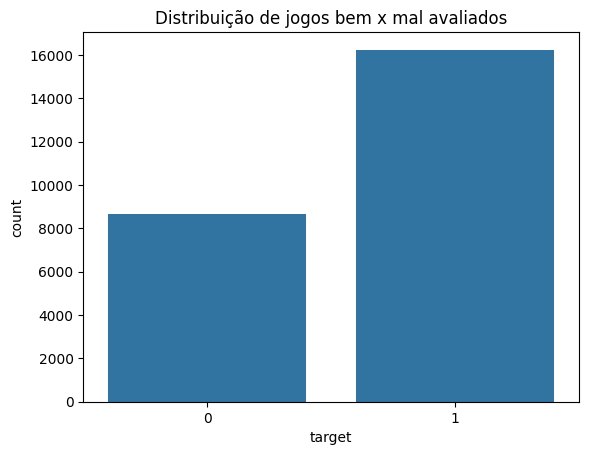

In [ ]:

df = df.dropna(subset=["Positive", "Negative"])
df["total_reviews"] = df["Positive"] + df["Negative"]
df = df[df["total_reviews"] > 50]

df["review_ratio"] = df["Positive"] / df["total_reviews"]
df["target"] = (df["review_ratio"] >= 0.75).astype(int)

print("Distribuição das classes:\n", df["target"].value_counts(normalize=True))
sns.countplot(x=df["target"])
plt.title("Distribuição de jogos bem x mal avaliados")
plt.show()


## 5. Seleção de features



In [ ]:

features_num = ["Price", "total_reviews", "Average playtime forever", "Peak CCU"]
features_cat = ["Genres"]

for col in features_num:
    df[col] = df[col].fillna(0)

for col in features_cat:
    df[col] = df[col].fillna("Unknown")

X = df[features_num + features_cat]
y = df["target"]


## 6. Divisão em treino e teste

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (19929, 5) Test: (4983, 5)


## 7. Pré-processamento

Foi usado o ColumnTransformer para aplicar diferentes transaformações para colunas numéricas e categóricas: StandardScaler para numéricas e OneHotEncoder para categóricas. Em seguida encapsulamos tudo em um Pipeline junto com o classificador.

In [ ]:

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), features_num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), features_cat)
    ]
)


## 8. Treinamento de modelos

Cada modelo tem vantagens: Logistic Regression proporciona coeficientes interpretáveis; Random Forest dá feature importance; XGBoost frequentemente entrega melhor performance com tuning.


=== Logistic ===
              precision    recall  f1-score   support

           0       0.59      0.17      0.26      1736
           1       0.68      0.94      0.79      3247

    accuracy                           0.67      4983
   macro avg       0.63      0.55      0.52      4983
weighted avg       0.65      0.67      0.60      4983



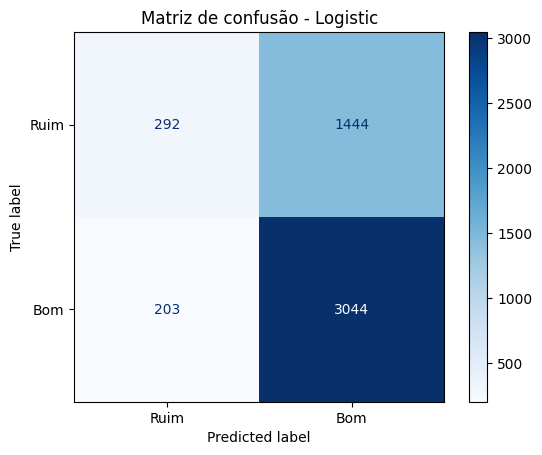

ROC-AUC: 0.64620700923504

=== RandomForest ===
              precision    recall  f1-score   support

           0       0.56      0.41      0.48      1736
           1       0.73      0.83      0.77      3247

    accuracy                           0.68      4983
   macro avg       0.64      0.62      0.62      4983
weighted avg       0.67      0.68      0.67      4983



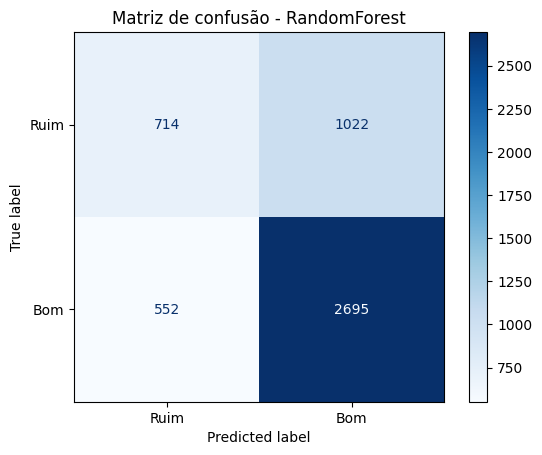

ROC-AUC: 0.7028316815663945


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:58:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost ===
              precision    recall  f1-score   support

           0       0.61      0.41      0.49      1736
           1       0.73      0.86      0.79      3247

    accuracy                           0.70      4983
   macro avg       0.67      0.64      0.64      4983
weighted avg       0.69      0.70      0.69      4983



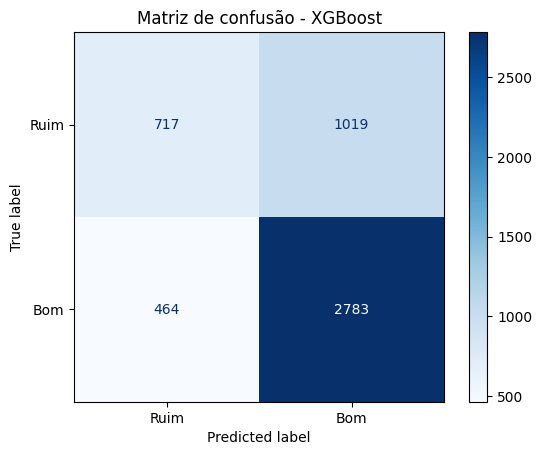

ROC-AUC: 0.7262246859561254


In [ ]:

models = {
    "Logistic": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42)
}

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ruim", "Bom"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Matriz de confusão - {name}")
    plt.show()

    if hasattr(pipe, "predict_proba"):
        y_proba = pipe.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
        print("ROC-AUC:", auc)


## 9. Otimização de hiperparâmetros (exemplo com XGBoost)
Os modelos foram avaliados com base em métricas de classificação, como precisão, recall, F1-score e ROC-AUC. De forma geral, Random Forest e XGBoost apresentaram desempenho superior à Regressão Logística, com melhor equilíbrio entre classes e maior capacidade de capturar padrões não-lineares.

Este estudo demonstrou a aplicação de aprendizado supervisionado para prever avaliações de jogos no Steam. Os resultados sugerem que variáveis relacionadas à popularidade (número de reviews) e características do jogo (gênero e preço) têm grande impacto sobre a percepção dos usuários. Como trabalhos futuros, pode-se explorar técnicas de balanceamento de classes, uso de
embeddings de texto para descrições de jogos e aplicação de modelos de deep learning.

In [ ]:

param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [3, 5, 7],
    "classifier__learning_rate": [0.01, 0.1, 0.3]
}

xgb_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", XGBClassifier(eval_metric="logloss"))])

grid = GridSearchCV(xgb_pipe, param_grid, cv=3, scoring="f1", n_jobs=-1)
grid.fit(X_train, y_train)

print("Melhores parâmetros:", grid.best_params_)
print("Melhor score CV (f1):", grid.best_score_)


Melhores parâmetros: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
Melhor score CV (f1): 0.7931740401925618
